## imports

In [61]:
from random import randrange as noise
import seaborn as sns
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

## create dummy data

In [62]:
camera_noise = 10
lidar_noise = 5

time_stamps = [i for i in range(100)]

x_gt = [i for i in range(100)]
y_gt = [math.sin(i/10)*20 + 50 for i in range(100)]

x_camera = [i + noise(-camera_noise, camera_noise) for i in x_gt]
y_camera = [i + noise(-camera_noise, camera_noise) for i in y_gt]

x_lidar = [i + noise(-lidar_noise, lidar_noise) for i in x_gt]
y_lidar = [i + noise(-lidar_noise, lidar_noise) for i in y_gt]

In [63]:
def plot(x_gt, y_gt, x1, y1, x2, y2, label_1='label_1', label_2='label_2', title='Title'):
    x_data = pd.DataFrame(zip(x_gt, x1, x2), columns=['x_gt', 'x_' + label_1, 'x_' + label_2]) 
    y_data = pd.DataFrame(zip(y_gt, y1, y2), columns=['y_gt', 'y_' + label_1, 'y_' + label_2]) 

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    sns.lineplot(data = x_data, ax=ax[0])
    sns.lineplot(data = y_data, ax=ax[1])

    ax[0].set(xlabel='time', ylabel='x_pos')
    ax[1].set(xlabel='time', ylabel='y_pos')
    plt.ylim(0, 100)
    fig.suptitle(title, fontsize=16)

    fig.show()

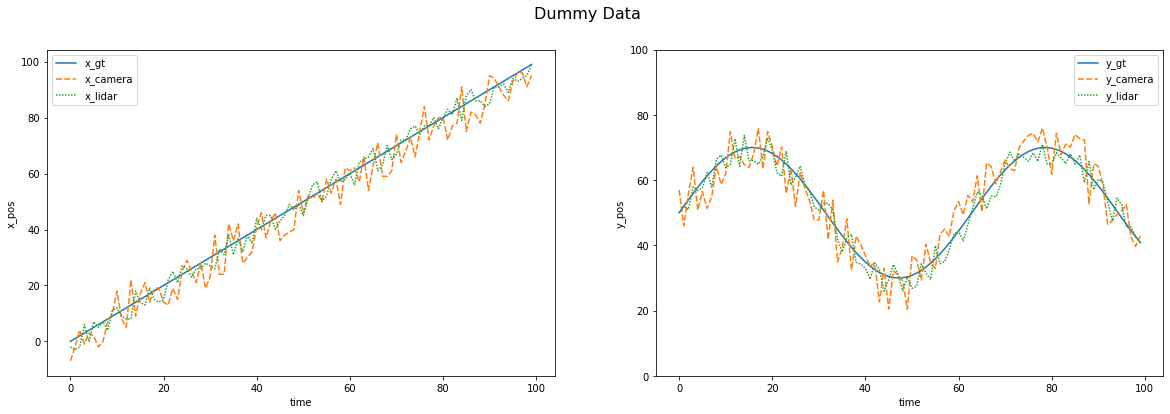

In [64]:
plot(x_gt, y_gt, x_camera, y_camera, x_lidar, y_lidar, label_1='camera', label_2='lidar', title='Dummy Data')

## initialise variables

In [65]:
def initialise_variables():
    prv_time = 0

    X = np.array([[x_camera[0]], [y_camera[0]], [0], [0]])

    P = np.array([[10, 0, 0, 0],
                [0, 10, 0, 0],
                [0, 0, 1000, 0],
                [0, 0, 0, 1000]])

    A = np.array([[1.0, 0, 1.0, 0],
                [0, 1.0, 0, 1.0],
                [0, 0, 1.0, 0],
                [0, 0, 0, 1.0]])

    H = np.array([[1.0, 0, 0, 0],
                [0, 1.0, 0, 0]])

    I = np.identity(4)

    Z = np.zeros([2, 1])

    # TODO: Look into initialising these values
    R = np.array([[10, 0],
                [0, 10]])
    noise_ax = 0.005
    noise_ay = 0.005

    Q = np.zeros([4, 4])

    return X, P, A, H, I, Z, Q, prv_time

## predict

In [66]:
def predict(X, P, Q, A):
    X = np.matmul(A, X)
    At = np.transpose(A)
    P = np.add(np.matmul(A, np.matmul(P, At)), Q)
    return X, P

## update

In [67]:
def update(Z, X, P, H, R, I):
    Y = np.subtract(Z, np.matmul(H, X))
    Ht = np.transpose(H)
    S = np.add(np.matmul(H, np.matmul(P, Ht)), R)
    K = np.matmul(P, Ht)
    Si = inv(S)
    K = np.matmul(K, Si)
    
    # New state
    X = np.add(X, np.matmul(K, Y))
    P = np.matmul(np.subtract(I ,np.matmul(K, H)), P)
    return X, P

## filter

In [68]:
def kalman_filter(x_measurements, y_measurements, measurement_time_stamps, R_value=10, noise_ax=0.005, noise_ay=0.005):
    
    X, P, A, H, I, Z, Q, prv_time = initialise_variables()
    R = np.array([[R_value, 0],
                 [0, R_value]])
    
    x_filtered = []
    y_filtered = []
    
    # iterate through sensor data
    for i in range (1, len(x_measurements)):
        new_measurement = [x_measurements[i], y_measurements[i]]

        cur_time = measurement_time_stamps[i]
        dt = cur_time - prv_time
        prv_time = cur_time

        dt_2 = dt * dt
        dt_3 = dt_2 * dt
        dt_4 = dt_3 * dt

        #Updating matrix A with dt value
        A[0][2] = dt
        A[1][3] = dt

        #Updating Q matrix
        Q[0][0] = dt_4/4*noise_ax
        Q[0][2] = dt_3/2*noise_ax
        Q[1][1] = dt_4/4*noise_ay
        Q[1][3] = dt_3/2*noise_ay
        Q[2][0] = dt_3/2*noise_ax
        Q[2][2] = dt_2*noise_ax
        Q[3][1] = dt_3/2*noise_ay
        Q[3][3] = dt_2*noise_ay

        #Updating sensor readings
        Z[0][0] = new_measurement[0]
        Z[1][0] = new_measurement[1]

        X, P = predict(X, P, Q, A)
        X, P = update(Z, X, P, H, R, I)

        x_filtered.append(X[0][0])
        y_filtered.append(X[1][0])

    return x_filtered, y_filtered


## results

In [69]:
x_filtered_camera, y_filtered_camera = kalman_filter(x_camera, y_camera, time_stamps, 10, 0.005, 0.01)
x_filtered_lidar, y_filtered_lidar = kalman_filter(x_lidar, y_lidar, time_stamps, 10, 0.05, 0.05)

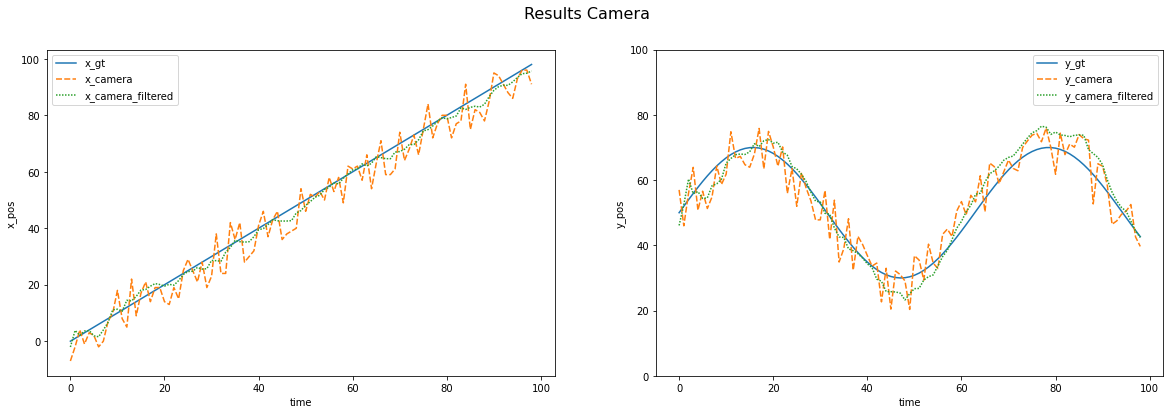

In [70]:
plot(x_gt, y_gt, x_camera, y_camera, x_filtered_camera, y_filtered_camera, label_1='camera', label_2='camera_filtered', title='Results Camera')

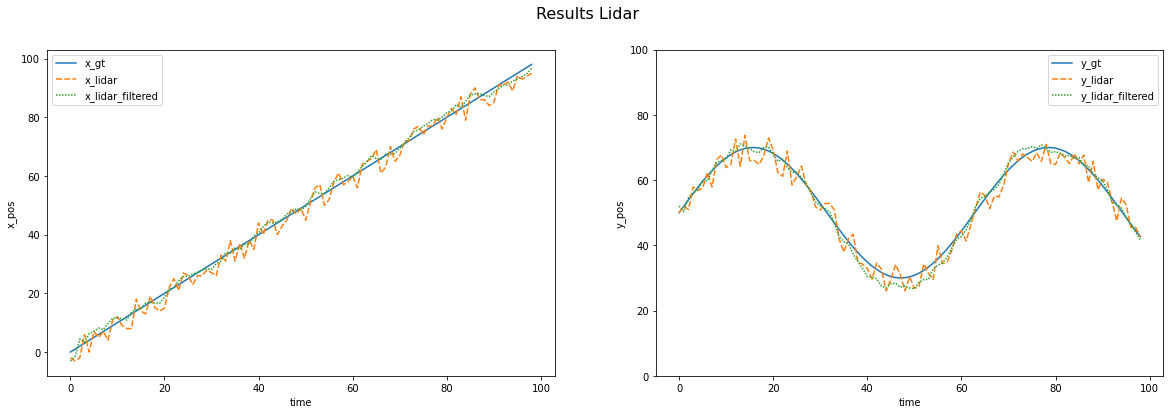

In [71]:
plot(x_gt, y_gt, x_lidar, y_lidar, x_filtered_lidar, y_filtered_lidar, label_1='lidar', label_2='lidar_filtered', title='Results Lidar')

In [72]:
x_rmse_camera = round(sum([(i[0] - i[1]) ** 2 for i in zip(x_filtered_camera, x_gt[1:])])/len(x_filtered_camera), 4)
y_rmse_camera = round(sum([(i[0] - i[1]) ** 2 for i in zip(y_filtered_camera, y_gt[1:])])/len(y_filtered_camera), 4)
x_rmse_lidar = round(sum([(i[0] - i[1]) ** 2 for i in zip(x_filtered_lidar, x_gt[1:])])/len(x_filtered_lidar), 4)
y_rmse_lidar = round(sum([(i[0] - i[1]) ** 2 for i in zip(y_filtered_lidar, y_gt[1:])])/len(y_filtered_lidar), 4)

print('x_rmse_camera: ', x_rmse_camera)
print('y_rmse_camera: ', y_rmse_camera)
print('x_rmse_lidar:  ', x_rmse_lidar)
print('y_rmse_lidar:  ', y_rmse_lidar)

x_rmse_camera:  7.2357
y_rmse_camera:  18.3377
x_rmse_lidar:   2.2508
y_rmse_lidar:   4.6493
